In [1]:
import mnist
import pandas as pd
import numpy as np
from skimage import transform
from PIL import Image
from matplotlib import pyplot as plt

### Part 1: Obtaining the Dataset

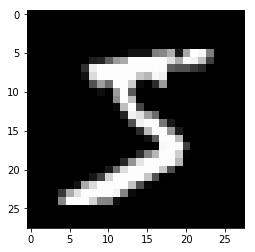

In [2]:
images = mnist.train_images()
labels = mnist.train_labels()

plt.imshow(images[0], cmap='gray')
plt.show()
#scipy.misc.toimage(scipy.misc.imresize(images[0,:,:] * -1 + 256, 10.))

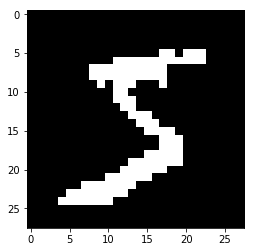

In [3]:
binarized_images = images[0:20]
binarized_images[binarized_images < 128] = -1
binarized_images[binarized_images >= 128] = 1

plt.imshow(binarized_images[0], cmap='gray')
plt.show()

### Part 2: Adding Noise

In [4]:
import pandas as pd
dfNoise = pd.read_csv('/Users/eric/MCSDS/AML/mp8/SupplementaryAndSampleData/NoiseCoordinates.csv')
dfNoise.head()

,Row Description,Noisy bit 0,Noisy bit 1,Noisy bit 2,Noisy bit 3,Noisy bit 4,Noisy bit 5,Noisy bit 6,Noisy bit 7,Noisy bit 8,Noisy bit 9,Noisy bit 10,Noisy bit 11,Noisy bit 12,Noisy bit 13,Noisy bit 14
0,Image 0 Row,21,3,10,27,19,24,7,0,25,6,7,15,14,17,23
1,Image 0 Column,17,17,22,9,20,5,2,3,12,26,5,24,6,23,3
2,Image 1 Row,26,9,4,0,20,5,23,3,14,21,15,2,15,3,27
3,Image 1 Column,17,3,20,22,6,24,18,10,20,8,21,20,24,1,7
4,Image 2 Row,13,24,24,11,0,11,26,18,12,12,17,8,20,0,6


In [22]:
x = np.array(dfNoise[dfNoise["Row Description"].str.contains("Row")])
y = np.array(dfNoise[dfNoise["Row Description"].str.contains("Column")])

In [27]:
## flip the bits specified in the noise file
nrows = x.shape[0]
ncols = x.shape[1]

noisy_images = binarized_images

for i in range(0,nrows):
        for j in range(1,ncols):
                bitx = x[i,j]
                bity = y[i,j]
                #print(i, j, bitx, bity)
                noisy_images[i, bitx, bity] = noisy_images[i, bitx, bity] * -1
                

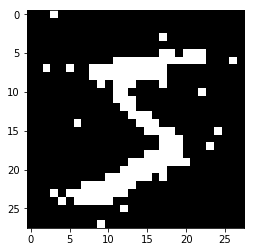

In [28]:
plt.imshow(noisy_images[0], cmap='gray')
plt.show()

### Part 3: Building a Boltzman Machine for denoising the images and using Mean-Field Inference

In [8]:
import numpy as np
dfInit = pd.read_csv('/Users/eric/MCSDS/AML/mp8/SupplementaryAndSampleData/InitialParametersModel.csv', header=None)

## repeat this array for each image
## essentially creating a 3D array where each element is this 2D array
npQ = np.dstack([np.array(dfInit)] * len(binarized_images))
#npQ[:,:,0]
dfInit.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.163002,0.943169,0.966341,0.106514,0.265544,0.347078,0.677093,0.029129,0.151272,0.599906,...,0.284758,0.312810,0.934028,0.151777,0.882616,0.713864,0.175875,0.011102,0.414077,0.616365
1,0.407106,0.825789,0.822867,0.009245,0.888955,0.295000,0.975410,0.142443,0.796760,0.607107,...,0.371722,0.482941,0.316986,0.843358,0.702200,0.579487,0.067614,0.212943,0.564381,0.547075
2,0.395082,0.462340,0.063882,0.079890,0.613154,0.446056,0.872171,0.749021,0.149508,0.104041,...,0.646302,0.422235,0.647065,0.421013,0.054016,0.152300,0.140960,0.315576,0.758664,0.739550
3,0.873560,0.368054,0.602058,0.304465,0.403247,0.856347,0.504113,0.747819,0.307421,0.891668,...,0.640066,0.807471,0.511449,0.619081,0.397573,0.377645,0.399303,0.667911,0.314972,0.885732
4,0.553960,0.579533,0.403402,0.908633,0.738997,0.676647,0.265314,0.290233,0.348706,0.677840,...,0.426305,0.796197,0.353715,0.556425,0.537348,0.475875,0.307498,0.910969,0.682640,0.368514


In [9]:
dfUpdate = pd.read_csv('/Users/eric/MCSDS/AML/mp8/SupplementaryAndSampleData/UpdateOrderCoordinates.csv')
dfUpdate.head()

,Row Description,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,...,Pixel 774,Pixel 775,Pixel 776,Pixel 777,Pixel 778,Pixel 779,Pixel 780,Pixel 781,Pixel 782,Pixel 783
0,Image 0 Row,26,15,13,1,22,27,9,2,12,...,19,27,13,4,6,12,15,0,7,10
1,Image 0 Column,4,15,5,4,17,17,27,6,24,...,8,22,14,8,4,11,19,15,15,22
2,Image 1 Row,0,27,3,25,20,22,5,21,23,...,11,18,11,12,14,5,14,11,27,3
3,Image 1 Column,18,13,25,26,22,4,0,14,10,...,3,5,18,5,13,14,24,27,1,19
4,Image 2 Row,10,7,8,22,23,1,3,0,9,...,27,2,19,10,16,26,16,27,20,2


In [74]:
import math

theta_H = 0.8
theta_X = 2
npQ = np.dstack([np.array(dfInit)] * len(binarized_images))

def getNeighbors(r,c,img):
    #r1 = c
    #c1 = r
    #r = r1
    #c = c1
    
    ## left neighbor
    x = r - 1
    y = c 
    if (x >= 0):
        left = npQ[x,y,img]
    else: 
        left = None
    
    #print(img, r, c, x, y, left)
    
    ## right neighbor
    x = r + 1
    y = c
    if (x < 28):
        right = npQ[x,y,img]
    else: 
        right = None

    ## upper neighbor
    x = r 
    y = c - 1

    if (y >= 0):
        up = npQ[x,y,img]
    else: 
        up = None

    ## lower neighbor
    x = r
    y = c + 1

    if (y < 28):
        down = npQ[x,y,img]
    else: 
        down = None
    
    ## center
    #x = r
    #y = c
    #center = npQ[x,y,img]
    
    
    #list = [left, right, up, down, center]
    
    list = [left, right, up, down]    
    
    return [x for x in list if x is not None]


vfe = np.zeros((20,11))
c = 10e-10

def calcVFE(img, npQ, epoch):
    
    ## calculate the VFE for initial Q and after each iteration
    logP = 0.0
    logQ = 0.0
    sumH = 0.0
    sumX = 0.0
    
    for x in range(28):
        for y in range(28):
            logQ += (npQ[x,y,img] * np.log(npQ[x,y,img] + c)) + ((1 - npQ[x,y,img]) * (1 - (np.log(npQ[x,y,img] + c))))

            neighbors = getNeighbors(x,y,img)

            #print(img, neighbors, reduce(lambda a, b: a*b, neighbors))

            #sumH += theta_H * (2 * npQ[x,y,img] - 1)  * reduce(lambda a, b: a*b, (2 * neighbors - 1))        
            
            ##for all pixels i
            ##for all neighbors of pixel i -> j
            ##sum(theta2 * (2 * H[i] - 1) * H[j]
            
            
            
            for neighbor in neighbors:            
                sumH += theta_H * ((2 * npQ[x,y,img]) - 1) * ((2 * neighbor) - 1) 
            
            ##for all pixels i
            ##for all neighbors of pixel i -> j
            ##sum(theta2 * (2 * H[i] - 1) * X[j]
            
            sumX += theta_X * (2 * npQ[x,y,img] - 1) * noisy_images[img,x,y]
    
    logP = sumH + sumX
    vfe[img,epoch] = logQ - logP    
    
    
## do this for 10 iterations
epochs = range(10)

for epoch in epochs:
    print(epoch + 1)
    
    for i in range(0,40,2):
        img = i/2              
        
        if (epoch == 0):
            calcVFE(img, npQ, epoch)
        
        for j in range(1,785):

            ## read the pixel value from the img with X,Y given by UpdateOrderCoordinates
            x = dfUpdate.iloc[i,j]
            y = dfUpdate.iloc[i + 1, j]

            ## observed value of X_i
            obsval = noisy_images[img,x,y]

            ## neighbors of the pixel at X,Y
            neighbors = getNeighbors(x,y,img)

            #print(img, x, y, neighbors)

            ## calculate pi_i
            sumH = 0.0
            sumX = 0.0
            sumHInv = 0.0
            sumXInv = 0.0
            
            for neighbor in neighbors:            
                sumH += theta_H * ((2 * neighbor) - 1)
                sumHInv += -1 * theta_H * ((2 * neighbor) - 1)
                #print(neighbor, num1, den1)
            
            sumX = theta_X * obsval
            sumXInv = -1 * theta_X * obsval
            
            e1 = math.exp((sumH + sumX))
            e2 = math.exp((sumHInv + sumXInv))
                         
            #den1 = -1 * (theta_X * ( 2 * obsval - 1 ))
            

            #numerator = math.exp((num1 + num2))
            #denomenator = numerator + math.exp(-1 * (num1 + den1))

            #pi_i = numerator / denomenator
            
            pi_i = e1 / (e1 + e2)
                         
            npQ[x,y,img] = pi_i
            
    
        calcVFE(img, npQ, epoch)
        

1
2
3
4
5
6
7
8
9
10


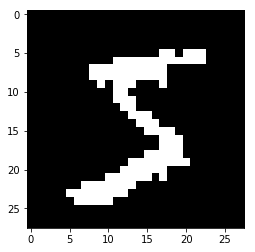

In [48]:
#npQ[:,:,0]

npQBin = npQ
npQBin[npQBin < 0.50] = 0
npQBin[npQBin >= 0.50] = 1

#img = pd.DataFrame(npQ[:,:])
#img[img < 0.5] = -1
#img[img >= 0.5] = 1

plt.imshow(npQBin[:,:,0], cmap='gray')
plt.show()

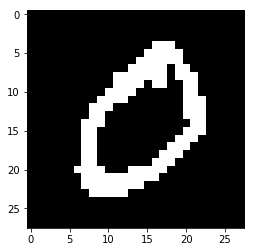

In [49]:
plt.imshow(npQBin[:,:,1], cmap='gray')
plt.show()

In [50]:
dfDenoised = pd.read_csv('/Users/eric/MCSDS/AML/mp8/SupplementaryAndSampleData/SampleDenoised.csv', header=None)
dfDenoised.head(2)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


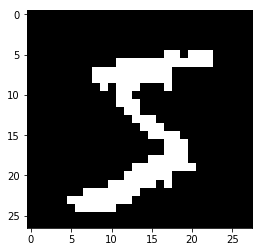

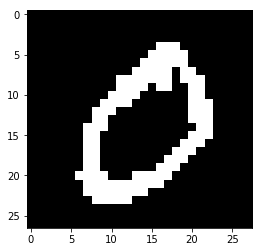

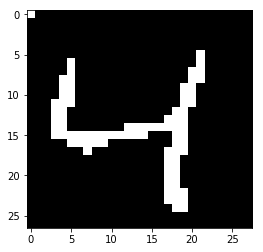

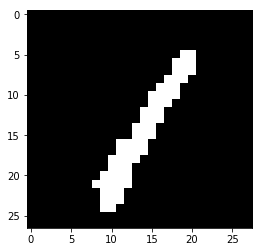

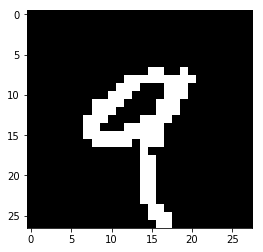

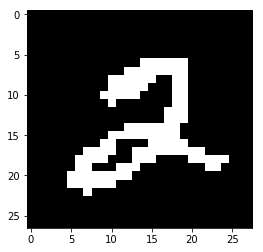

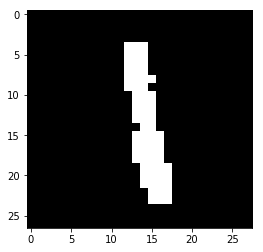

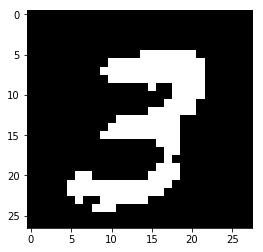

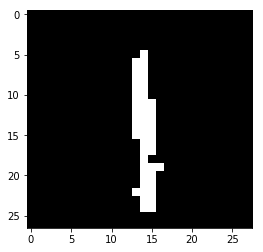

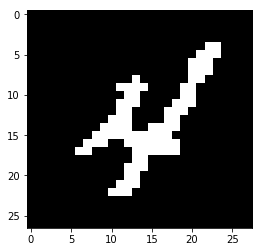

In [51]:
npDen = np.array(dfDenoised)
for i in range(0,279,28):
    startcol = i
    endcol = i + 28
    plt.imshow(npDen[0:27,startcol:endcol], cmap="gray")
    plt.show()    


### Part 4: Turning in the energy function values computed initially and after each iteration

In [73]:
vfe[1,0:10]

array([ 1528.37825414,  3293.12015877,  3296.97998133,  3296.09545289,
        3295.92162545,  3295.90768528,  3295.90664825,  3295.90656694,
        3295.90656034,  3295.90655979])

### Part 5: Displaying the reconstructed images

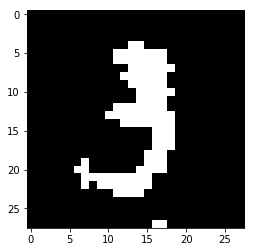

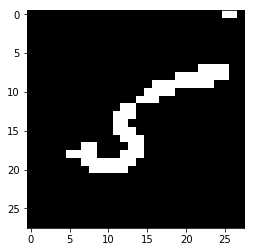

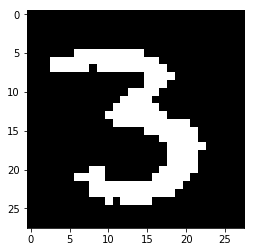

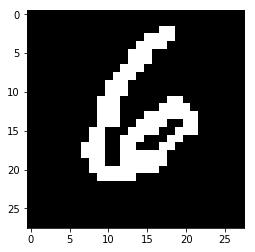

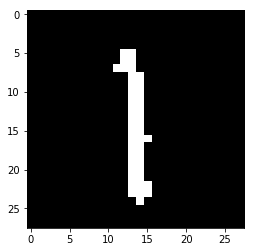

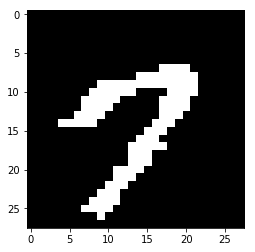

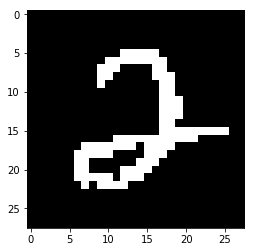

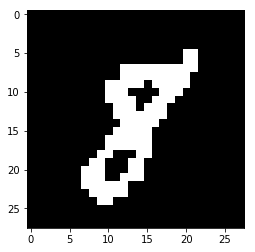

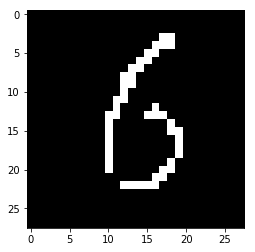

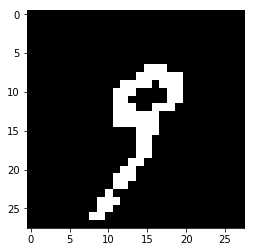

In [35]:
for i in range(10,20):
    plt.imshow(npQBin[:,:,i], cmap='gray')
    plt.show()

In [52]:
arr = npQBin[:,:,10]

for i in range(11,20):
    a = npQBin[:,:,i]
    arr = np.hstack((arr, a))
    
arr.shape

(28, 280)

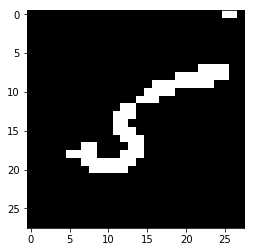

In [53]:
plt.imshow(arr[:,28:56], cmap='gray')
plt.show()

In [57]:
np.savetxt('/Users/eric/MCSDS/AML/mp8/denoised.csv', arr, delimiter=',', fmt="%i")